# Imports

In [208]:
# Essentials
import requests
import json
import pandas as pd

# Math
import scipy as sc
import statsmodels.api as sm

# Gensim
import gensim
import gensim.downloader as model_api

# SKLearn
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.neighbors import KDTree
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans

# Misc
import numpy as np
import re

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# Global Variables

In [2]:
WORDS_VECTORS = model_api.load("glove-wiki-gigaword-50")

In [125]:
PCA_COMPRESS = 2

In [213]:
sns.set()

# Request

**Filters set on the request:**
- subreddit: askreddit
- number of comments: minimum 100
- score: minimum 1000
- size: 500 (only 100 pulled?)
- filter: score, title, num_comments (number of comments)


In [305]:
r = requests.get("https://api.pushshift.io/reddit/submission/search/?subreddit=askreddit&num_comments=>100&filter=score,title,num_comments&score=>1000&size=500")
content = json.loads(r.content)
content = content["data"]

In [306]:
len(content)

100

# Data Frame

In [307]:
df = pd.DataFrame(content)

In [308]:
df.head()

,num_comments,score,title
0,1240,1204,"If you have ever contemplated suicide, why? An..."
1,1952,3298,If you could end all suffering in the world (h...
2,7515,29495,If you were a mad scientist with absolutely no...
3,3225,5352,What’s the most bullshit excuse you ever heard...
4,28626,46309,What do you guys think happens when we die?


# Word Embedding

## TF-IDF

In [309]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['title'])

Xd = X.toarray()
Xd = PCA(PCA_COMPRESS).fit(Xd.T).components_.T
Xd = sm.add_constant(Xd)

pred = Xd @ sc.linalg.inv(Xd.T @ Xd) @ Xd.T @ df['score'].values
print("OLS R^2: ", r2_score(df['score'], pred))

OLS R^2:  0.020695650353196204


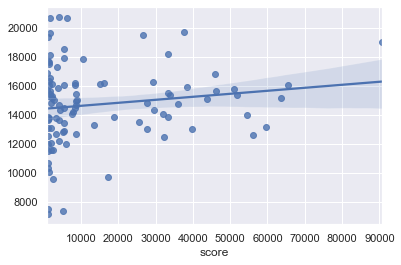

In [326]:
sns.regplot(x="score", y=pred, data=df);

### Conclusion

Word embedding through bag of words TF-IDF method is not a great predictor of a post's score based on the title used.

## LDA

In [310]:
n_features = 1000
n_components = 10
n_top_words = 20

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

data_samples = df.title

# Use tf (raw term count) features for LDA.
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)

tf_feature_names = tf_vectorizer.get_feature_names()

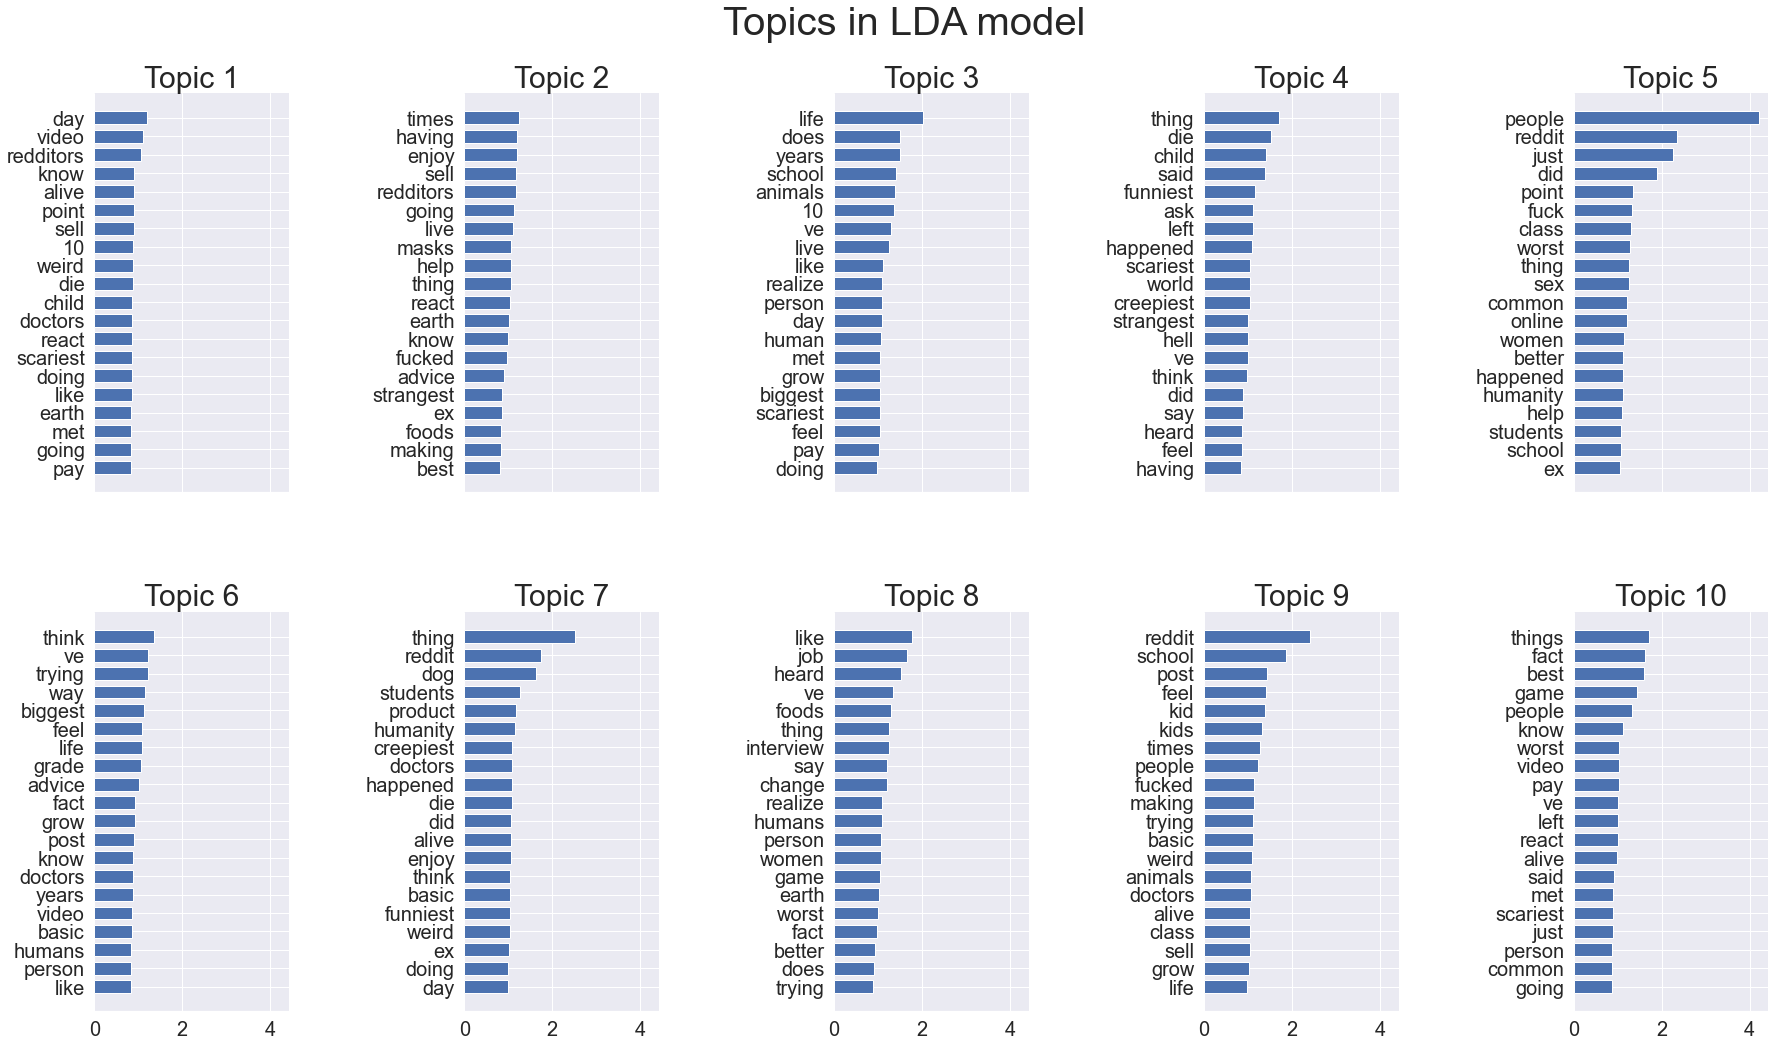

In [327]:
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

### Conclusion:

LDA did a thing?

# Sentence Embedding

### Word cleaning

In [311]:
replaceDict = dict({
'{':" ", '}':" ", ',':"", '.':" ", '!':" ", '\\':" ", '/':" ", '$':" ", '%':" ",
'^':" ", '?':" ", '\'':" ", '"':" ", '(':" ", ')':" ", '*':" ", '+':" ", '-':" ",
'=':" ", ':':" ", ';':" ", ']':" ", '[':" ", '`':" ", '~':" ",
})

rep = dict((re.escape(k), v) for k, v in replaceDict.items())
pattern = re.compile("|".join(rep.keys()))
def replacer(text):
    return rep[re.escape(text.group(0))]

words = df.title.str.replace(pattern, replacer).str.lower().str.split()
words = pd.DataFrame(words.tolist())

In [312]:
def soft_get(w):
    try:
        return WORDS_VECTORS[w]
    except KeyError:
        return np.zeros(WORDS_VECTORS.vector_size)
def map_vectors(row):
    try:
        return np.sum(
            row.loc[row.notna()].apply(soft_get)
        )
    except:
        return np.zeros(WORDS_VECTORS.vector_size)
emb = pd.DataFrame(words.apply(map_vectors, axis=1).tolist())

### Normalizing the data

In [313]:
norm_emb = StandardScaler().fit_transform(emb)

In [314]:
sgdr = SGDRegressor()
sgdr.fit(norm_emb, df.score)
sgdr.score(norm_emb, df.score)

0.3898800179764069

In [315]:
# used for plotting below
df["pred_emb"] = sgdr.predict(emb)
df["pred_norm_emb"] = sgdr.predict(norm_emb)

### Non-normalized prediction graph

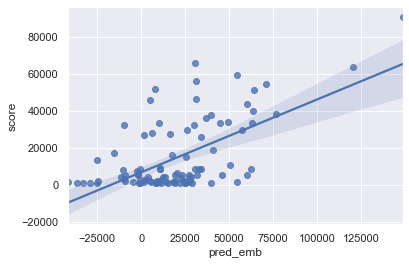

In [322]:
sns.regplot(x="pred_emb", y="score", data=df);

### Normalized prediction graph

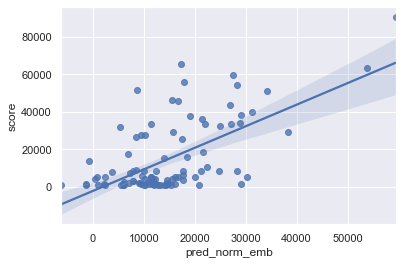

In [323]:
sns.regplot(x="pred_norm_emb", y="score", data=df);

### Combinging EMB + num_comments

In [316]:
emb_com = pd.concat([emb, df["num_comments"]], axis = 1)

In [317]:
norm_emb_com = StandardScaler().fit_transform(emb_com)

In [318]:
sgdr = SGDRegressor()
sgdr.fit(norm_emb_com, df.score)
sgdr.score(norm_emb_com, df.score)

0.7844607495547078

In [319]:
# used for plotting below
df["pred_emb_com"] = sgdr.predict(emb_com)
df["pred_norm_emb_com"] = sgdr.predict(norm_emb_com)

### Non-normalized prediction with number of comments graph

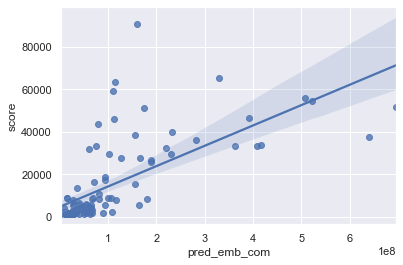

In [324]:
sns.regplot(x="pred_emb_com", y="score", data=df);

### Normalized prediction with number of comments graph

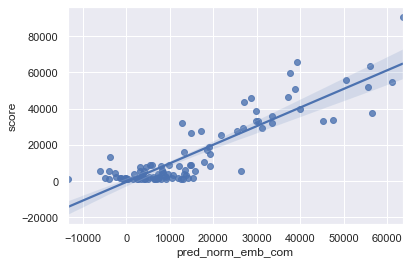

In [325]:
sns.regplot(x="pred_norm_emb_com", y="score", data=df);

### Conclusion

Sentence embedding is **MUCH** better method of predicting a post's score based on it's title. Based on the results above, it's roughly 20x better than word embedding. Normalizing the data helped to fix it's incredible skewedness due to the vast difference in score of the outlayers .

Keeping that in mind, I decided to test the relationship between sentence embedding and the number of comments a post has received to predict it's score, and we can see that this relationship is twice as good in terms of prediction accuracy as just plain old sentence embedding.  Normalizing the data had the same effect as it did when we did not take into consideration the number of comments. We can see the normalization clearly represented in the graph above.